# Exercise 2
Consider the grid-world shown in the below figure. In each (non-grey) cell, it is possible to perform five actions: move up, down, left, right, or do nothing, as long as the resulting move stays inside the grid world. Grey cells are obstacles and are not allowed. We would like to find the optimal value function and optimal policy that minimize the following cost:

$$
\min \sum_{n=0}^{\infty} \alpha^n g_n(x_n)
$$

with discount factor $ \alpha = 0.99 $ and where the instantaneous cost is defined as:

$$
g_n(x_n) = 
\begin{cases}
-1 & \text{if } x_n \text{ is a violet cell} \\
0 & \text{if } x_n \text{ is a white cell} \\
1 & \text{if } x_n \text{ is a green cell} \\
10 & \text{if } x_n \text{ is a red cell}
\end{cases}
$$

In a Jupyter notebook, answer the following questions:

**(a)** Implement the value iteration algorithm to solve the problem (initialize the value function to 0). How many iterations does it take to attain convergence? (We assume here that convergence happens when all the elements of the value function do not change more than $ 10^{-6} $ in a new iteration).

**(b)** Implement the policy iteration algorithm to solve the problem (use the version that solves the linear equation $ (I - \alpha A) J_\mu = \bar{g} $ ). Start with an initial policy that does not move. How many iterations does it take to converge?

**(c)** Compare the solutions and convergence/complexity of each algorithm to solve this problem.

![Grid World](img/gridWorld.png)


In [1]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
iterations = 10000
tol = 1e-6
alpha = 0.99

Grid = np.array([[0,      0,      1,  0, -1],
                 [0, np.nan,      1,  0, 10],
                 [0,     10, np.nan,  1,  0],
                 [1,      0,      0, 10, -1]])





In [2]:
def value_iteration(Grid, iterations, tol, alpha=0.99) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    J_prime = np.zeros((iterations+1, Grid.shape[0], Grid.shape[1]), dtype=float)
    J_prime[0] = Grid
    norm_list = []
    tol_list = []

    for i in range(iterations):
        for state in range(Grid.size):
            x, y = np.unravel_index(state, Grid.shape)
            if np.isnan(Grid[x, y]):
                J_prime[i, x, y] = np.nan
                continue
            J_curr = J_prime[i, x, y]
            action_up = 0
            action_down = 0
            action_left = 0
            action_right = 0

            # Check if the action up is possible and calculate the cost
            if x-1 >= 0 and not np.isnan(Grid[x-1, y]):
                action_up = J_prime[i, x-1, y]
            # Check if the action down is possible and calculate the cost
            if x+1 < Grid.shape[0] and not np.isnan(Grid[x+1, y]):
                action_down = J_prime[i, x+1, y]
            # Check if the action left is possible and calculate the cost
            if y-1 >= 0 and not np.isnan(Grid[x, y-1]):
                action_left = J_prime[i, x, y-1]
            # Check if the action right is possible and calculate the cost
            if y+1 < Grid.shape[1] and not np.isnan(Grid[x, y+1]):
                action_right = J_prime[i, x, y+1]

            # Determine the minimum cost among the possible actions
            J_opt = np.inf
            J_opt = np.nanmin([J_curr, action_up, action_down, action_left, action_right])

            # Update the cost-to-go function
            J_prime[i+1, x, y] = Grid[x, y] + alpha * J_opt

        ''' 
        Check again the way the norm is calculated!!! Not sure if it is correct
        '''        

        # Calculate the norm of the cost-to-go function
        norm = np.sqrt(np.nansum(J_prime[i] ** 2))
        norm_list.append(norm)
        
        if i != 0:
            current_tol = np.abs(norm_list[i] - norm_list[i-1])
            tol_list.append(current_tol)
            if current_tol < tol:
                print(f"Converged after {i+1} iterations. Final cost-to-go -\n{J_prime[i]}")
                break
    return J_prime[i], norm_list, tol_list

Converged after 1520 iterations. Final cost-to-go -
[[-95.0794778  -96.0398768  -97.0099768  -98.9999768  -99.9999768 ]
 [-94.12868279          nan -96.0298768  -98.0099768  -88.9999768 ]
 [-93.18739573 -82.25552154          nan -97.0099768  -98.9999768 ]
 [-91.25552154 -90.34296609 -89.4395362  -88.9999768  -99.9999768 ]]


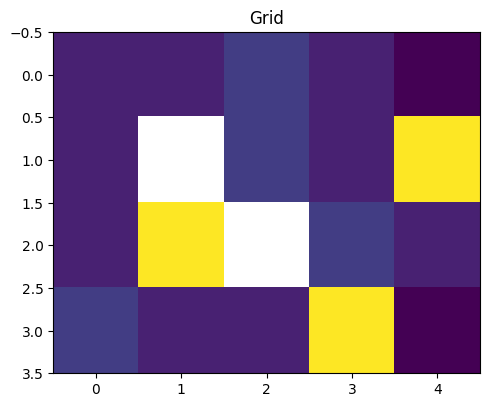

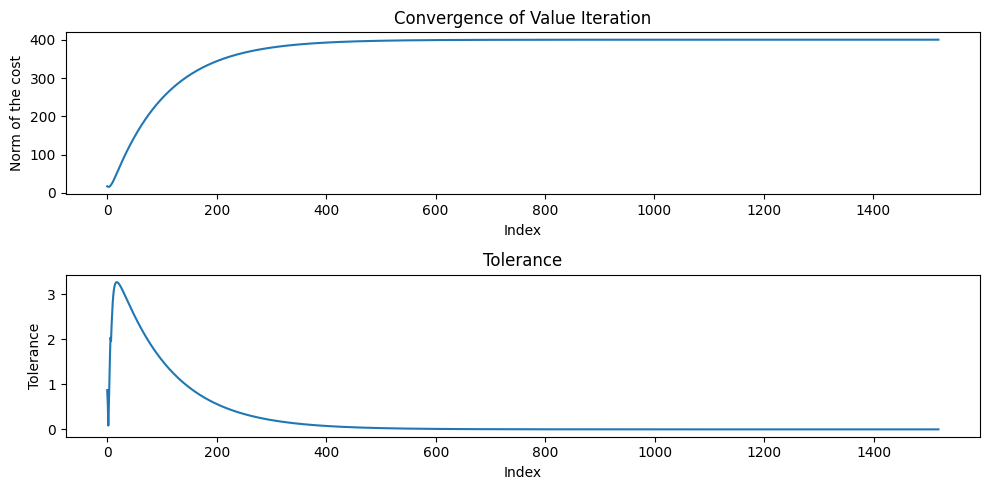

In [3]:
J_VAL_ITER, J_norm_hist_VAL_ITER, J_TOL_ITER = value_iteration(iterations=iterations, tol=tol, alpha=alpha, Grid=Grid)

# Write a function to plot the grid, cost-to-go function, and the tolerance
def plot_results(Grid, J_norm_hist_VAL_ITER, J_TOL_ITER):
    plt.figure(figsize=(5, 5), layout="tight")
    plt.subplot(1, 1, 1)
    plt.imshow(Grid, cmap='viridis')
    plt.title("Grid")
    # plt.colorbar()
    plt.figure(figsize=(10, 5), layout="tight")
    plt.subplot(2, 1, 1)
    plt.plot(J_norm_hist_VAL_ITER)
    plt.xlabel("Index")
    plt.ylabel("Norm of the cost")
    plt.title("Convergence of Value Iteration")
    plt.subplot(2, 1, 2)
    plt.plot(J_TOL_ITER)
    plt.xlabel("Index")
    plt.ylabel("Tolerance")
    plt.title("Tolerance")
    plt.show()

plot_results(Grid, J_norm_hist_VAL_ITER, J_TOL_ITER)

In [4]:
J_VAL_ITER

array([[-95.0794778 , -96.0398768 , -97.0099768 , -98.9999768 ,
        -99.9999768 ],
       [-94.12868279,          nan, -96.0298768 , -98.0099768 ,
        -88.9999768 ],
       [-93.18739573, -82.25552154,          nan, -97.0099768 ,
        -98.9999768 ],
       [-91.25552154, -90.34296609, -89.4395362 , -88.9999768 ,
        -99.9999768 ]])

# Part b

In [ ]:
def determine_policy(J_prime: np.ndarray):
    policy = np.full(J_prime.shape, 'Obstacle', dtype=object)

    for state in range(J_prime.size):
        x, y = np.unravel_index(state, J_prime.shape)
        if np.isnan(J_prime[x, y]):
            continue
        J_curr = J_prime[x, y]
        
        action_up = action_down = action_left = action_right = np.inf

        # Check if the action up is possible and calculate the cost
        if x-1 >= 0 and not np.isnan(J_prime[x-1, y]):
            action_up = J_prime[x-1, y]
        # Check if the action down is possible and calculate the cost
        if x+1 < J_prime.shape[0] and not np.isnan(J_prime[x+1, y]):
            action_down = J_prime[x+1, y]
        # Check if the action left is possible and calculate the cost
        if y-1 >= 0 and not np.isnan(J_prime[x, y-1]):
            action_left = J_prime[x, y-1]
        # Check if the action right is possible and calculate the cost
        if y+1 < J_prime.shape[1] and not np.isnan(J_prime[x, y+1]):
            action_right = J_prime[x, y+1]
        
        # Find the minimum cost for the possible actions
        J_min = np.inf
        optimal_action = 'Stay'
        if J_curr < J_min and not np.isnan(J_curr):
            J_min = J_curr
            optimal_action = 'Stay'
        if action_up < J_min and not np.isnan(action_up):
            J_min = action_up
            optimal_action = 'Up'
        if action_down < J_min and not np.isnan(action_down):
            J_min = action_down
            optimal_action = 'Down'
        if action_left < J_min and not np.isnan(action_left):
            J_min = action_left
            optimal_action = 'Left'
        if action_right < J_min and not np.isnan(action_right):
            J_min = action_right
            optimal_action = 'Right'
        policy[x, y] = optimal_action

    return policy
print(determine_policy(J_VAL_ITER))

[['Right' 'Right' 'Right' 'Right' 'Stay']
 ['Up' 'Obstacle' 'Right' 'Up' 'Up']
 ['Up' 'Left' 'Obstacle' 'Right' 'Down']
 ['Up' 'Left' 'Left' 'Right' 'Stay']]


In [ ]:
def policy_iteration(Grid, iterations, tol, alpha=0.99):
    norm_list = []
    obstacles = np.zeros((Grid.shape,1))
    obstacles[6] = obstacles[12] = 1
    A = np.zeros((18,18))
    I = np.eye(18)

    iterations = 1000
    for i in range(iterations):
        J_u = np.linalg.inv(I - alpha * A) @ np.delete(Grid, [6, 12])
        # insert back the obstacles
        J_u = np.insert(J_u, 6, np.nan)
        J_u = np.insert(J_u, 12, np.nan)
        J_u = J_u.reshape(Grid.shape)
        norm = np.sqrt(np.nansum(J_u ** 2))
        norm_list.append(norm)

        if i != 0:
            current_tol = np.abs(norm_list[i] - norm_list[i-1])
            if current_tol < tol:
                print(f"Converged after {i+1} iterations. Final cost-to-go -\n{J_u}")
                break

            A = np.zeros((18,18))
            enumerate_A = enumerate(iter(A))
            for state in range(Grid.size):
                x, y = np.unravel_index(state, Grid.shape)
                if np.isnan(Grid[x, y]):
                    continue
                row, col = next(enumerate_A, (None, None))
                J_curr = J_u[x, y]
                action_up = np.inf
                action_down = np.inf
                action_left = np.inf
                action_right = np.inf

                # Check if the action up is possible and calculate the cost
                if x-1 >= 0 and not np.isnan(Grid[x-1, y]):
                    action_up = J_u[x-1, y]
                # Check if the action down is possible and calculate the cost
                if x+1 < Grid.shape[0] and not np.isnan(Grid[x+1, y]):
                    action_down = J_u[x+1, y]
                # Check if the action left is possible and calculate the cost
                if y-1 >= 0 and not np.isnan(Grid[x, y-1]):
                    action_left = J_u[x, y-1]
                # Check if the action right is possible and calculate the cost
                if y+1 < Grid.shape[1] and not np.isnan(Grid[x, y+1]):
                    action_right = J_u[x, y+1]
                
                # Determine the minimum cost among the possible actions
                J_min = np.inf
                optimal_action = ''
                if J_curr < J_min and not np.isnan(J_curr):
                    J_min = J_curr
                    optimal_action = 'Stay'
                if action_up < J_min and not np.isnan(action_up):
                    J_min = action_up
                    optimal_action = 'Up'
                if action_down < J_min and not np.isnan(action_down):
                    J_min = action_down
                    optimal_action = 'Down'
                if action_left < J_min and not np.isnan(action_left):
                    J_min = action_left
                    optimal_action = 'Left'
                if action_right < J_min and not np.isnan(action_right):
                    J_min = action_right
                    optimal_action = 'Right'

                A[row, row] = 1


        



In [37]:
A = np.zeros((18,18))
I = np.eye(18)
alpha = 0.99
obstacles = np.zeros(Grid.shape)
J_u = np.linalg.inv(I - alpha * A) @ np.delete(Grid, [6, 12])
J_u = np.insert(J_u, 6, 1)
J_u = np.insert(J_u, 12, 1)

Grid.shape
np.delete(Grid, [6, 12]).shape



(18,)